# WLS - Code Examples Part 1

## Example 1

In [182]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

In [183]:
# Sample data from a hypothetical physics experiment
# x represents an independent variable
# y_obs represents the observed dependent variable
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y_obs = np.array([2.3, 3.8, 5.1, 6.9, 8.2, 10.3, 11.8, 14.1])

In [184]:
# Standard deviation for each data point
sigma = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [185]:
# The weights for WLS are the inverse of the variance (1 / sigma^2)
weights = 1.0 / (sigma**2)

# Add a constant to the independent variable to include an intercept in the model
X = sm.add_constant(x)

In [186]:
print(X)


[[1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]
 [1. 5.]
 [1. 6.]
 [1. 7.]
 [1. 8.]]


### The Intercept Term in Linear Regression 

In a linear regression model, the relationship between a dependent variable ($y$) and an independent variable ($x$) is expressed as:

$y = \beta_0 + \beta_1x + \epsilon$

Here, $\beta_0$ is the **intercept** and $\beta_1$ is the slope. The intercept ($\beta_0$) represents the expected value of $y$ when $x$ is zero. In the context of our code, it represents the baseline spending when income is zero. The `statsmodels` library, by default, expects you to explicitly include this intercept term as a column of ones in your predictor matrix. This is because it treats the linear model as:

$y = \beta_0 \cdot 1 + \beta_1 \cdot x + \epsilon$

By adding a constant column of ones to your predictor variables, you're creating a matrix where the first column is a representation of the constant term (1), allowing the model to estimate the coefficient $\beta_0$.

### How `sm.add_constant` Works

The `sm.add_constant(income)` function takes the `income` array and adds a new column of ones to the beginning of it.

* **Original `income` array:**
    `[1.0, 2.0, ..., 8.0]`

* **After `sm.add_constant(income)`:**
    `[[1.0, 1.0], [1.0, 2.0], ..., [1.0, 8.0]]`
    
This modified array, named `X`, now has two columns. The first column (all ones) is used to calculate the intercept, while the second column (`income`) is used to calculate the slope. This is why the in the comment to the code we mentioned "(for the intercept)"; it's explicitly explaining the purpose of adding the constant column.

In [187]:
# Fit the Weighted Least Squares model
wls_model = sm.WLS(y_obs, X, weights=weights)
results = wls_model.fit()

# --- Print the detailed summary of the regression ---
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            WLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1443.
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           2.22e-08
Time:                        01:38:21   Log-Likelihood:               0.049782
No. Observations:                   8   AIC:                             3.900
Df Residuals:                       6   BIC:                             4.059
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6375      0.126      5.078      0.0

### Output Analysis

The parameters `t`, `P>|t|`, and `[0.025 0.975]` are essential for **hypothesis testing** and **confidence interval estimation**. They help us determine if the relationship between our independent and dependent variables is statistically significant.

### The t-statistic ($t$)

The **t-statistic** measures how many standard deviations the estimated coefficient is from zero. In other words, it quantifies the evidence against the null hypothesis ($H_0$), which states that the true coefficient is zero (i.e., there is no relationship between the independent and dependent variables). A larger absolute value of $t$ indicates that the coefficient is less likely to be zero by chance.

$$t = \frac{\text{Estimated Coefficient} - 0}{\text{Standard Error of the Coefficient}}$$

In our output:
* For the intercept $\beta_0$: $t = \frac{0.6375}{0.126} \approx 5.078$.
* For the slope coefficient $\beta_1$: $t = \frac{1.5857}{0.042} \approx 37.986$.

The very high $t$-statistic for the slope coefficient ($37.986$) strongly suggests that the slope is not zero, meaning there is a significant relationship between $x$ and $y$.

### The P-value ($P>|t|$)

The **P-value** is the probability of observing a $t$-statistic as extreme as, or more extreme than, the one calculated, assuming the null hypothesis is true. A small P-value provides strong evidence to **reject the null hypothesis**. The common threshold for significance is $\alpha = 0.05$. If our P-value is less than 0.05, we can conclude that the coefficient is statistically significant. 

In our output:
* For the intercept $\beta_0$: the P-value is 0.002
* For the slope coefficient $\beta_1$: the P-value is 0.000
* This means the probability of observing these coefficients if there were no real relationship is practically zero. You can confidently reject the null hypothesis and conclude that both the intercept and the slope are statistically significant.

### The Confidence Interval ([0.025 0.975])

The **confidence interval** is a range of values that likely contains the true, unknown value of the coefficient. The `[0.025 0.975]` columns represent the **95% confidence interval**, meaning that if you were to repeat our sampling and analysis many times, 95% of the calculated confidence intervals would contain the true population parameter. The key takeaway is to see if this interval includes zero. If the interval does not contain zero, it is further evidence that the coefficient is statistically significant, consistent with a low P-value.

In our output:
* For the intercept $\beta_0$: The 95% confidence interval is `[0.330, 0.945]`. Since this range does not contain zero, the intercept is statistically significant.
* For the income coefficient ($\beta_1$): The 95% confidence interval is `[1.484, 1.688]`. This range also does not contain zero.

In [188]:
# Degrees of Freedom
dof = results.df_resid
print(f"Degrees of Freedom: {dof}")

nobs = results.nobs
print(f"Number of Observations: {nobs}")

condition_number = results.condition_number
print(f"Condition Number: {condition_number}")


Degrees of Freedom: 6.0
Number of Observations: 8.0
Condition Number: 5.307859000400287


In [189]:
# --- 1) Calculate RSS using results.resid (unweighted residuals) ---
rss_unweighted = np.sum(results.resid**2)
print(f"1) RSS from unweighted residuals (results.resid): {rss_unweighted:.4f}")


# --- 2) Calculate RSS using results.wresid (weighted residuals) ---
# This is the value that WLS minimizes.
rss_weighted_from_wresid = np.sum(results.wresid**2)
print(f"2) Weighted RSS from weighted residuals (results.wresid): {rss_weighted_from_wresid:.4f}")


# --- 3) Calculate RSS manually using the linear equation ---
# Get the coefficients from the model results
intercept, slope = results.params
# Calculate the predicted y values
y_pred = intercept + slope * x
# Calculate the residuals manually
manual_residuals = y_obs - y_pred
# Square and sum the residuals
rss_unweighted_manual = np.sum(manual_residuals**2)
print(f"3) Manually calculated RSS (unweighted): {rss_unweighted_manual:.4f}")


# --- 4) Calculate weighted RSS manually ---
# Use the manual residuals and the weights
manual_weighted_residuals_sq = (manual_residuals**2) * weights
rss_weighted_manual = np.sum(manual_weighted_residuals_sq)
print(f"4) Manually calculated Weighted RSS: {rss_weighted_manual:.4f}")

# --- Verification ---
# Note that the unweighted RSS values from (1) and (3) should be identical.
# The weighted RSS values from (2) and (4) should also be identical.
# The small differences might occur due to floating-point precision.

1) RSS from unweighted residuals (results.resid): 0.8626
2) Weighted RSS from weighted residuals (results.wresid): 1.8848
3) Manually calculated RSS (unweighted): 0.8626
4) Manually calculated Weighted RSS: 1.8848


In [190]:
# 1) print tss value using results.centered_tss
centered_tss_sm = results.centered_tss
print(f"Total weighted sum of squares centered about the mean (statsmodels results.centered_tss): {centered_tss_sm:.4f}")

# 2) print tss value using results.uncentered_tss
uncentered_tss_sm = results.uncentered_tss
print(f"Uncentered total weighted sum of squares (statsmodels results.uncentered_tss): {uncentered_tss_sm:.4f}")

# 3) calculate centered_tss manually
# First, calculate the weighted mean of y_obs
weighted_mean_y = np.sum(weights * y_obs) / np.sum(weights)
# Then, calculate the centered_tss using the formula
weighted_centered_tss_manual = np.sum(weights * (y_obs - weighted_mean_y)**2)
print(f"\nManual calculation of total (weighted) sum of squares centered about the mean: {weighted_centered_tss_manual:.4f}")

# 4) calculate uncentered_tss manually
# The formula is the sum of weighted squared y values
weighted_uncentered_tss_manual = np.sum(weights * y_obs**2)
print(f"Manual calculation of uncentered total (weighted) sum of squares: {weighted_uncentered_tss_manual:.4f}")

# --- Manual Unweighted Calculations ---

# 5) calculate unweighted centered_tss manually
# First, calculate the standard (unweighted) mean of y_obs
unweighted_mean_y = np.mean(y_obs)
# Then, calculate the unweighted centered_tss
# Formula: sum((y_obs - mean(y_obs))^2)
unweighted_centered_tss_manual = np.sum((y_obs - unweighted_mean_y)**2)
print(f"\nManual calculation of unweighted TSS centered about the mean: {unweighted_centered_tss_manual:.4f}")

# 6) calculate unweighted uncentered_tss manually
# The formula is the sum of squared y values without weighting
# Formula: sum(y_obs^2)
unweighted_uncentered_tss_manual = np.sum(y_obs**2)
print(f"Manual calculation of uncentered unweighted TSS: {unweighted_uncentered_tss_manual:.4f}")

Total weighted sum of squares centered about the mean (statsmodels results.centered_tss): 455.1540
Uncentered total weighted sum of squares (statsmodels results.uncentered_tss): 1511.9919

Manual calculation of total (weighted) sum of squares centered about the mean: 455.1540
Manual calculation of uncentered total (weighted) sum of squares: 1511.9919

Manual calculation of unweighted TSS centered about the mean: 116.4488
Manual calculation of uncentered unweighted TSS: 604.7300


In [191]:
ess = results.ess # The explained sum of squares.
print(f"Weighted Explained Sum of Squares (ESS): {ess:.4f}")

# Manually calculate the ESS
# Get the fitted values (y_hat) from the model
y_hat = results.predict(X)

# Calculate the weighted mean of y_obs
weighted_mean_y = np.sum(weights * y_obs) / np.sum(weights)

# Calculate ESS using the formula: sum(weights * (y_hat - weighted_mean_y)^2)
ess_weighted_manual = np.sum(weights * (y_hat - weighted_mean_y)**2)
print(f"Weighted Explained Sum of Squares (ESS) manual calculation: {ess_weighted_manual:.4f}")

# Calculate the unweighted mean of y_obs
unweighted_mean_y = np.mean(y_obs)

# Finally, calculate the unweighted ESS using the formula: sum((y_hat - unweighted_mean_y)^2)
ess_unweighted_manual = np.sum((y_hat - unweighted_mean_y)**2)
print(f"Explained Sum of Squares (ESS) unweighted manual calculation: {ess_unweighted_manual:.4f}")

Weighted Explained Sum of Squares (ESS): 453.2692
Weighted Explained Sum of Squares (ESS) manual calculation: 453.2692
Explained Sum of Squares (ESS) unweighted manual calculation: 105.6192


In [192]:
# Get the number of observations and parameters
n = results.nobs
p = results.df_model + 1  # df_model is number of explanatory variables, add 1 for intercept

print(f"Number of observations (n): {n}")
print(f"Number of parameters (p): {p}")

Number of observations (n): 8.0
Number of parameters (p): 2.0


In [193]:
r_squared = results.rsquared
print(f"Weighted R-squared (statsmodels results.rsquared): {r_squared:.4f}")

r_squared_adj = results.rsquared_adj
print(f"Weighted Adjusted R-squared (statsmodels results.rsquared_adj): {r_squared_adj:.4f}")

# --- Manual calculation of Weighted R-squared ---

r_squared_manual_weighted = 1 - rss_weighted_manual / centered_tss_manual
print(f"\nManual Weighted R-squared (1 - RSS_w/TSS_w): {r_squared_manual_weighted:.4f}")

# Manual calculation of Weighted Adjusted R-squared
# Formula: 1 - (1 - R^2_w) * ((n-1)/(n-p))
r_squared_adj_manual_weighted = 1 - (1 - r_squared_manual_weighted) * ((n - 1) / (n - p))
print(f"Manual Weighted Adjusted R-squared: {r_squared_adj_manual_weighted:.4f}")

# --- Manual calculation of Unweighted R-squared ---
# We need to calculate the unweighted centered TSS first
unweighted_mean_y = np.mean(y_obs)
unweighted_centered_tss = np.sum((y_obs - unweighted_mean_y)**2)

r_squared_manual_unweighted = 1 - rss_unweighted_manual / unweighted_centered_tss
print(f"\nManual Unweighted R-squared (1 - RSS/TSS): {r_squared_manual_unweighted:.4f}")

# Manual calculation of Unweighted Adjusted R-squared
# Formula: 1 - (1 - R^2_unweighted) * ((n-1)/(n-p))
r_squared_adj_manual_unweighted = 1 - (1 - r_squared_manual_unweighted) * ((n - 1) / (n - p))
print(f"Manual Unweighted Adjusted R-squared: {r_squared_adj_manual_unweighted:.4f}")

# Formula: ESS_weighted / TSS_centered_weighted
r_squared_manual_weighted_2 = ess_manual / centered_tss_manual
print(f"\nManual Weighted R-squared (alternative formula) (ESS_w/TSS_w): {r_squared_manual_weighted_2:.4f}")

# Formula: ESS_unweighted / TSS_centered_unweighted
r_squared_manual_unweighted_2 = ess_unweighted / unweighted_centered_tss
print(f"Manual Unweighted R-squared alternative formula (ESS/TSS): {r_squared_manual_unweighted_2:.4f}")

Weighted R-squared (statsmodels results.rsquared): 0.9959
Weighted Adjusted R-squared (statsmodels results.rsquared_adj): 0.9952

Manual Weighted R-squared (1 - RSS_w/TSS_w): 0.9959
Manual Weighted Adjusted R-squared: 0.9952

Manual Unweighted R-squared (1 - RSS/TSS): 0.9926
Manual Unweighted Adjusted R-squared: 0.9914

Manual Weighted R-squared (alternative formula) (ESS_w/TSS_w): 0.9959
Manual Unweighted R-squared alternative formula (ESS/TSS): 0.9070


In [194]:
# Chi-Squared
chi_squared = np.sum(((y_obs - results.predict()) / sigma)**2)
print(f"Chi-Squared: {chi_squared:.4f}")

# Reduced Chi-Squared
reduced_chi_squared = chi_squared / dof
print(f"Reduced Chi-Squared: {reduced_chi_squared:.4f}")

Chi-Squared: 1.8848
Reduced Chi-Squared: 0.3141


In [195]:
# --- Root Mean Squared Error (RMSE) Calculations ---
print("\n--- Root Mean Squared Error (RMSE) ---")

# RMSE from statsmodels (this is an unweighted RMSE)
rmse_val = rmse(y_obs, results.fittedvalues)
print(f"RMSE (statsmodels.tools.eval_measures.rmse method): {rmse_val:.4f}")

# Manual calculation of Unweighted RMSE
# Formula: sqrt(sum of squared unweighted residuals / number of observations)
rmse_manual_unweighted = np.sqrt(rss_unweighted_manual / n)
print(f"Manual Unweighted RMSE: {rmse_manual_unweighted:.4f}")

# Manual calculation of Weighted RMSE
# Formula: sqrt(sum of squared weighted residuals / sum of weights)
rmse_manual_weighted = np.sqrt(rss_weighted_manual / np.sum(weights))
print(f"Manual Weighted RMSE: {rmse_manual_weighted:.4f}")


--- Root Mean Squared Error (RMSE) ---
RMSE (statsmodels.tools.eval_measures.rmse method): 0.3284
Manual Unweighted RMSE: 0.3284
Manual Weighted RMSE: 0.1869


In [196]:
# --- Standard Error of the Regression (SER) ---

# 1) Calculate weighted SER manually
# Formula: sqrt(RSS_weighted / dof)
dof = results.df_resid
ser_manual_weighted = np.sqrt(rss_weighted_manual / dof)
print(f"\nManual Weighted SER: {ser_manual_weighted:.4f}")

# Compare with statsmodels SER calculation
ser_sm = np.sqrt(results.ssr / results.df_resid)
print(f"Statsmodels SER (results.ssr / results.df_resid): {ser_sm:.4f}")


Manual Weighted SER: 0.5605
Statsmodels SER (results.ssr / results.df_resid): 0.5605


In [197]:
# --- Standard Error of the Regression (SER) Calculations ---
print("\n--- Standard Error of the Regression (SER) ---")

# SER from statsmodels results (this is a weighted SER)
# It is the square root of the weighted RSS divided by the degrees of freedom
ser_sm = np.sqrt(results.ssr / results.df_resid)
print(f"SER (from statsmodels results): {ser_sm:.4f}")

# Manual calculation of Weighted SER
# This should match the value from statsmodels
# Formula: sqrt(sum of squared weighted residuals / degrees of freedom)
ser_manual_weighted = np.sqrt(rss_weighted_manual / dof)
print(f"Manual Weighted SER: {ser_manual_weighted:.4f}")

# Manual calculation of Unweighted SER
# Formula: sqrt(sum of squared unweighted residuals / degrees of freedom)
ser_manual_unweighted = np.sqrt(rss_unweighted_manual / dof)
print(f"Manual Unweighted SER: {ser_manual_unweighted:.4f}")


--- Standard Error of the Regression (SER) ---
SER (from statsmodels results): 0.5605
Manual Weighted SER: 0.5605
Manual Unweighted SER: 0.3792


In [ ]:
n = results.nobs
p = results.df_model + 1

# --- MSE values from statsmodels results ---
print("--- Statsmodels Results (Weighted) ---")
mse_model_sm = results.mse_model
print(f"Mean Squared Error of the Model (mse_model): {mse_model_sm:.4f}")

mse_resid_sm = results.mse_resid
print(f"Mean Squared Error of the Residuals (MSE) (mse_resid): {mse_resid_sm:.4f}")

mse_total_sm = results.mse_total
print(f"Total Mean Squared Error (mse_total): {mse_total_sm:.4f}")

# --- Manual Calculations ---
print("\n--- Manual Calculations ---")

# 1. MSE Model
mse_model_manual_weighted = ess_weighted_manual / (p - 1)
mse_model_manual_unweighted = ess_unweighted_manual / (p - 1)
print(f"Manual Weighted mse_model: {mse_model_manual_weighted:.4f} (Should match statsmodels)")
print(f"Manual Unweighted mse_model: {mse_model_manual_unweighted:.4f}")

# 2. MSE Residuals
mse_resid_manual_weighted = rss_weighted_manual / (n - p)
mse_resid_manual_unweighted = rss_unweighted_manual / (n - p)
print(f"\nManual Weighted mse_resid: {mse_resid_manual_weighted:.4f} (Should match statsmodels)")
print(f"Manual Unweighted mse_resid: {mse_resid_manual_unweighted:.4f}")

# 3. MSE Total
mse_total_manual_weighted = weighted_centered_tss_manual / (n - 1)
mse_total_manual_unweighted = unweighted_centered_tss_manual / (n - 1)
print(f"\nManual Weighted mse_total: {mse_total_manual_weighted:.4f} (Should match statsmodels)")
print(f"Manual Unweighted mse_total: {mse_total_manual_unweighted:.4f}")

--- Statsmodels Results (Weighted) ---
Mean Squared Error of the Model (mse_model): 453.2692
Mean Squared Error of the Residuals (mse_resid): 0.3141
Total Mean Squared Error (mse_total): 65.0220

--- Manual Calculations ---
Manual Weighted mse_model: 453.2692 (Should match statsmodels)
Manual Unweighted mse_model: 105.6192

Manual Weighted mse_resid: 0.3141 (Should match statsmodels)
Manual Unweighted mse_resid: 0.1438

Manual Weighted mse_total: 65.0220 (Should match statsmodels)
Manual Unweighted mse_total: 16.6355


> To review the details about Log-Likelihood, AIC, and BIC, see [here](../01_basics/aic-and-bic.ipynb).

In [205]:
print("--- Information Criteria from statsmodels ---")

llf = results.llf # Log-likelihood of model
print(f"Log-Likelihood of the Model (llf) from statsmodels: {llf:.4f}")

aic = results.aic
print(f"Akaike Information Criterion (AIC) from statsmodels: {aic:.4f}")

bic = results.bic
print(f"Bayesian Information Criterion (BIC) from statsmodels: {bic:.4f}")

# --- Manual Calculations ---
print("\n--- Manual Calculation Verification ---")

# Get necessary components from results
n = results.nobs
p = results.df_model + 1  # Number of parameters (intercept + slope)
ssr = results.ssr         # Weighted sum of squared residuals

# 1. Manual Log-Likelihood
# Formula: -n/2*log(2*pi) + 0.5*sum(log(weights)) - ssr/2
log_likelihood_manual = (-n / 2) * np.log(2 * np.pi) + (0.5 * np.sum(np.log(weights))) - (chi_squared / 2)
print(f"Manual Log-Likelihood: {log_likelihood_manual:.4f}")

# 2. Manual AIC
# Formula: -2 * llf + 2 * p
aic_manual = -2 * log_likelihood_manual + 2 * p
print(f"Manual AIC: {aic_manual:.4f}")

# 3. Manual BIC
# Formula: -2 * llf + p * log(n)
bic_manual = -2 * log_likelihood_manual + p * np.log(n)
print(f"Manual BIC: {bic_manual:.4f}")


--- Information Criteria from statsmodels ---
Log-Likelihood of the Model (llf) from statsmodels: 0.0498
Akaike Information Criterion (AIC) from statsmodels: 3.9004
Bayesian Information Criterion (BIC) from statsmodels: 4.0593

--- Manual Calculation Verification ---
Manual Log-Likelihood: -2.6751
Manual AIC: 9.3501
Manual BIC: 9.5090


In [211]:
import numpy as np
import statsmodels.api as sm

# --- Assume previous setup from your notebook ---
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y_obs = np.array([2.3, 3.8, 5.1, 6.9, 8.2, 10.3, 11.8, 14.1])
sigma = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
weights = 1.0 / (sigma**2)
X = sm.add_constant(x)
wls_model = sm.WLS(y_obs, X, weights=weights)
results = wls_model.fit()
# --- End of assumed setup ---


print("--- Final Corrected Log-Likelihood Calculation ---")

# --- Get necessary components from the fitted model ---
n = results.nobs
ssr = results.ssr         # Weighted Sum of Squared Residuals
unbiased_scale = results.scale # ssr / df_resid
llf_from_results = results.llf

print(f"\n1) Log-Likelihood from results object: {llf_from_results:.4f}")
print(f"   (This is based on the MLE of scale, NOT the reported 'results.scale')")
print(f"   Reported unbiased scale (ssr/df_resid): {unbiased_scale:.4f}")

# --- Manual Calculation using the correct MLE of scale ---

# First, calculate the Maximum Likelihood Estimate for the scale parameter
mle_scale = ssr / n
print(f"   MLE for scale (ssr/n): {mle_scale:.4f}")


# Now, use the simplified formula derived from substituting the MLE scale
term1 = -n / 2 * (np.log(2 * np.pi) + 1)
term2 = 0.5 * np.sum(np.log(weights))
term3 = -n / 2 * np.log(mle_scale) # or -n/2 * np.log(ssr/n)
llf_manual_correct = term1 + term2 + term3

print(f"\n2) Manual LLF using the correct formula: {llf_manual_correct:.4f}")
print("   (This should now match the statsmodels value exactly)")

# --- For completeness: The calculation for a fixed scale=1.0 ---
llf_manual_fixed_scale = (-n / 2) * np.log(2 * np.pi) + (0.5 * np.sum(np.log(weights))) - (ssr / 2.0)
print(f"\n3) Manual LLF using a fixed scale=1.0: {llf_manual_fixed_scale:.4f}")
print("   (This is the value from the original manual attempt)")

--- Final Corrected Log-Likelihood Calculation ---

1) Log-Likelihood from results object: 0.0498
   (This is based on the MLE of scale, NOT the reported 'results.scale')
   Reported unbiased scale (ssr/df_resid): 0.3141
   MLE for scale (ssr/n): 0.2356

2) Manual LLF using the correct formula: 0.0498
   (This should now match the statsmodels value exactly)

3) Manual LLF using a fixed scale=1.0: -2.6751
   (This is the value from the original manual attempt)


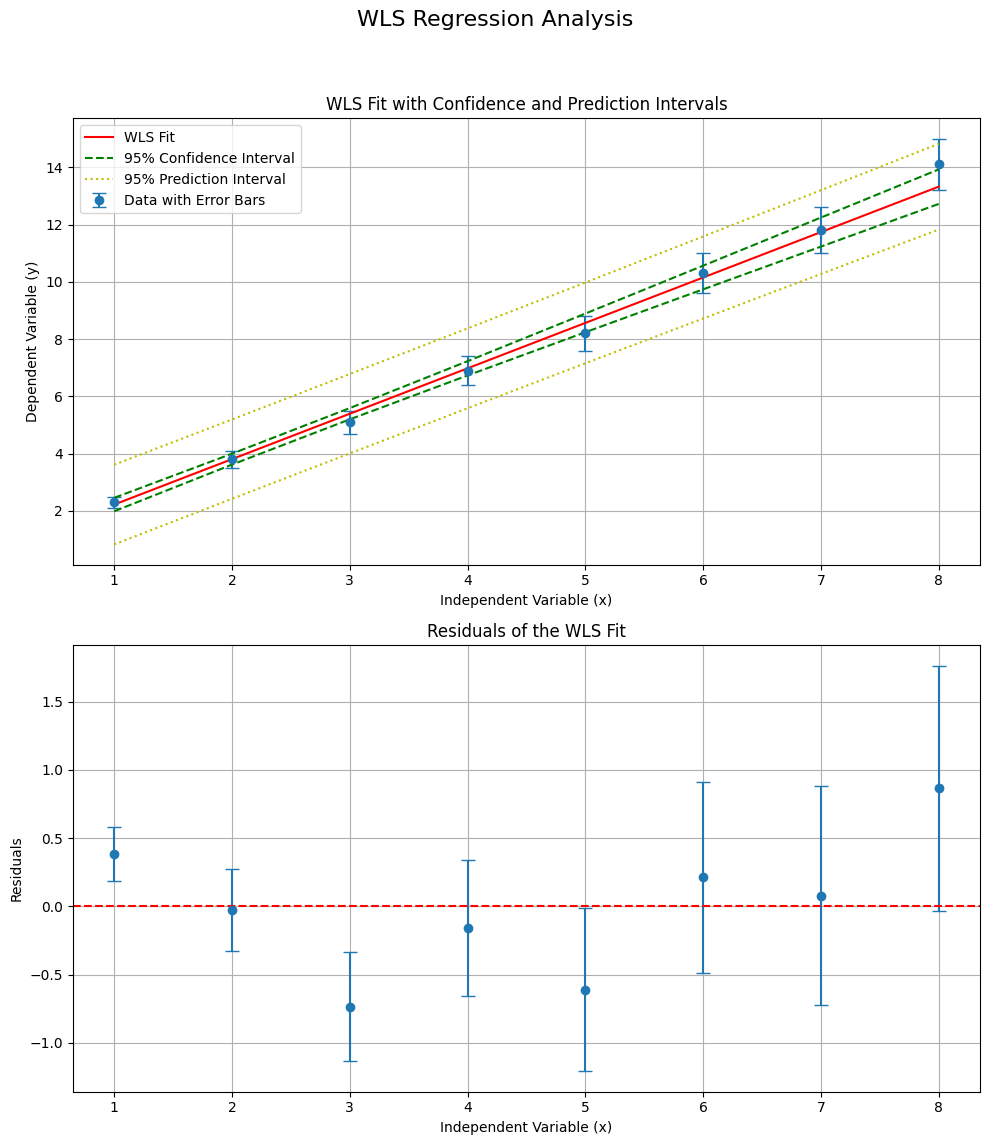

In [201]:
# --- Generate and display plots ---

# Create a figure and axes for the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
fig.suptitle('WLS Regression Analysis', fontsize=16)

# --- Plot 1: WLS Fit with Confidence and Prediction Intervals ---
ax1.errorbar(x, y_obs, yerr=sigma, fmt='o', label='Data with Error Bars', capsize=5)
ax1.plot(x, results.fittedvalues, 'r-', label='WLS Fit')

# Get prediction intervals
predictions = results.get_prediction(X)
prediction_summary = predictions.summary_frame(alpha=0.05)

# Plot confidence and prediction intervals
ax1.plot(x, prediction_summary['mean_ci_lower'], 'g--', label='95% Confidence Interval')
ax1.plot(x, prediction_summary['mean_ci_upper'], 'g--')
ax1.plot(x, prediction_summary['obs_ci_lower'], 'y:', label='95% Prediction Interval')
ax1.plot(x, prediction_summary['obs_ci_upper'], 'y:')

ax1.set_xlabel("Independent Variable (x)")
ax1.set_ylabel("Dependent Variable (y)")
ax1.set_title("WLS Fit with Confidence and Prediction Intervals")
ax1.legend()
ax1.grid(True)


# --- Plot 2: Residuals Plot ---
ax2.errorbar(x, residuals, yerr=sigma, fmt='o', capsize=5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel("Independent Variable (x)")
ax2.set_ylabel("Residuals")
ax2.set_title("Residuals of the WLS Fit")
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()